In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Q-learning vs double Q-learning

In [86]:
class simpleMDP():
    Start_State = "A"
    Terminal_State = "T"
    State_Actions = {"A":np.arange(2),"B":np.arange(20),"T":[0]}
    
    def __init__(self, s=Start_State):
        self.state = s
        
    @classmethod
    def new(cls):
        return simpleMDP()
    
    def is_terminated(self):
        return self.state == simpleMDP.Terminal_State
    
    def step(self,action):
        if self.state=="A":
            if action==0:
                # left
                self.state="B"
                return 0
            elif action==1:
                # right
                self.state=simpleMDP.Terminal_State
                return 0

        elif self.state=="B":
            if action in simpleMDP.State_Actions["B"]:
                self.state=simpleMDP.Terminal_State
                return np.random.randn()-0.1
        raise ValueError("state-action pair not valid")

    @classmethod
    def Q(cls):
        return {"A":np.random.randn(2),"B":np.random.randn(20),"T":[0]}
    
class Logger():
    def __init__(self, log_fn=lambda *x:x):
        self.buffer = []
        self.log_fn = log_fn
        
    def __call__(self,*value):
        self.buffer.append(self.log_fn(*value))
        
    def dump(self):
        out = self.buffer
        self.buffer = []
        return out

In [122]:
def Q_learning(env, num_episode=300, step_size=0.5, epsilon=0.1, discount = 0.9, log=lambda *x:None):
    Q = env.Q()
    for i in range(num_episode):
        eps = env.new()
        s_seq,a_seq,r_seq = [],[],[]
        while not eps.is_terminated():
            s = eps.state
            s_seq.append(s)
            # determine action
            if np.random.rand()<epsilon:
                # act randomly
                a = np.random.choice(env.State_Actions[s])
            else:
                # act greedily
                a = np.argmax(Q[s])
            # take action
            r = eps.step(a)
            r_seq.append(r)
            a_seq.append(a)
            # update
            Q[s][a]=Q[s][a]+step_size*(r+discount*max(Q[eps.state])-Q[s][a])
        s_seq.append(eps.state)
        log(s_seq,a_seq,r_seq)
    return Q


def double_Q_learning(env, num_episode=300, step_size=0.5, epsilon=0.1, discount = 0.9, log=lambda *x:None):
    Q1,Q2 = env.Q(),env.Q()
    for i in range(num_episode):
        eps = env.new()
        s_seq,a_seq,r_seq = [],[],[]
        while not eps.is_terminated():
            s = eps.state
            s_seq.append(s)
            # determine action
            if np.random.rand()<epsilon:
                # act randomly
                a = np.random.choice(env.State_Actions[s])
            else:
                # act greedily
                a = np.argmax(Q1[s]+Q2[s])
            # take action
            r = eps.step(a)
            r_seq.append(r)
            a_seq.append(a)
            # update
            if np.random.rand()<0.5:
                # update Q1
                Q1[s][a]=Q1[s][a]+step_size*(r+discount*Q2[eps.state][np.argmax(Q1[eps.state])]-Q1[s][a])
            else:
                # update Q2
                Q2[s][a]=Q2[s][a]+step_size*(r+discount*Q1[eps.state][np.argmax(Q2[eps.state])]-Q2[s][a])
        s_seq.append(eps.state)
        log(s_seq,a_seq,r_seq)
    return Q1,Q2

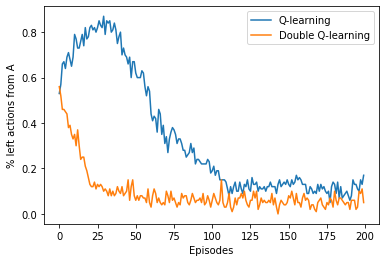

In [123]:
fn = lambda s,a,r: a[0]
log = Logger(fn)
N = 100
num_episode=200

Q_actions = np.zeros(num_episode)
DQ_actions = np.zeros(num_episode)
for i in range(N):
    _ = Q_learning(simpleMDP, num_episode=num_episode,log=log)
    Q_actions += np.array(log.dump())==0
    _ = double_Q_learning(simpleMDP, num_episode=num_episode,log=log)
    DQ_actions += np.array(log.dump())==0

fig,ax = plt.subplots(1,1)
ax.plot(Q_actions/N, label="Q-learning")
ax.plot(DQ_actions/N, label="Double Q-learning")
ax.set_xlabel("Episodes")
ax.set_ylabel("% left actions from A")
ax.legend()

# Q-learning vs Sarsa

In [124]:
class CliffWalking():
    Start_State = (0,0)
    Terminal_State = (11,0)
    State_Actions = dict([((i,j),[0,1,2,3]) for i in range(12) for j in range(4)])
    State_Actions[Terminal_State]=[0]
    
    def __init__(self, s=Start_State):
        self.state = s
    
    @classmethod
    def new(cls):
        return CliffWalking()
    
    def is_terminated(self):
        return self.state == CliffWalking.Terminal_State
    
    def step(self,action):
        s = self.state
        # act
        if action==0:
            # up
            self.state = (s[0],min(s[1]+1,3))
        elif action==1:
            # right
            self.state = (min(s[0]+1,11),s[1])
        elif action==2:
            # down
            self.state = (s[0],max(s[1]-1,0))
        elif action==3:
            # left
            self.state = (max(s[0]-1,0),s[1])
        else:
            raise ValueError("state-action pair not valid")        
        
        # reward
        if self.state[0] in range(1,11) and self.state[1]==0:
            # cliff
            self.state = CliffWalking.Start_State
            return -100
        else:
            return -1

    @classmethod
    def Q(cls):
        q = dict([((i,j),np.random.randn(4)) for i in range(12) for j in range(4)])
        q[CliffWalking.Terminal_State]=[0]
        return q

In [125]:
def Sarsa(env, num_episode=300, step_size=0.5, epsilon=0.1, discount = 0.9, log=lambda *x:None):
    Q = env.Q()
    for i in range(num_episode):
        # initialize
        eps = env.new()
        s_seq,a_seq,r_seq = [],[],[]
        
        # determine action
        s = eps.state
        a = np.random.choice(env.State_Actions[s]) if np.random.rand()<epsilon else np.argmax(Q[s])
        
        while not eps.is_terminated():
            s_seq.append(s)
            
            # take action
            r = eps.step(a)
            r_seq.append(r)
            a_seq.append(a)
            
            # determine next action
            _s = eps.state
            _a = np.random.choice(env.State_Actions[_s]) if np.random.rand()<epsilon else np.argmax(Q[_s])
            
            
            # update
            Q[s][a]=Q[s][a]+step_size*(r+discount*Q[_s][_a]-Q[s][a])
            s = _s
            a = _a
            
        s_seq.append(eps.state)
        log(s_seq,a_seq,r_seq)
    return Q


In [139]:
def optimal_seq(env, q, max_step=200):
    eps = env.new()
    s_seq,a_seq,r_seq = [],[],[]
    i=0
    while not eps.is_terminated() and i<max_step:
        i+=1
        s = eps.state
        s_seq.append(s)
        a = np.argmax(q[s])
        a_seq.append(a)
        r = eps.step(a)
        r_seq.append(r)
    s_seq.append(eps.state)
    return s_seq,a_seq,r_seq

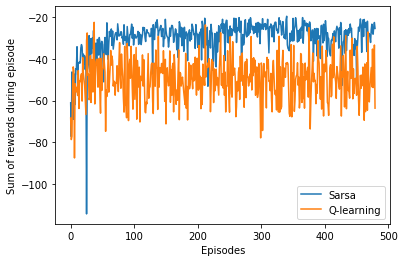

In [190]:
fn = lambda s,a,r: sum(r)
log = Logger(fn)
num_episode=500
N = 50
r_Sarsa = np.zeros(num_episode)
r_Q = np.zeros(num_episode)
for i in range(N):
    q_Sarsa = Sarsa(CliffWalking, num_episode=num_episode, discount=1.0,log=log)
    r_Sarsa += log.dump()
    q_Q = Q_learning(CliffWalking, num_episode=num_episode, discount=1.0,log=log)
    r_Q += log.dump()

fig,ax = plt.subplots(1,1)
ax.plot(r_Sarsa[20:]/N, label="Sarsa")
ax.plot(r_Q[20:]/N, label="Q-learning")
ax.set_xlabel("Episodes")
ax.set_ylabel("Sum of rewards during episode")
ax.legend()

In [192]:
s_Q,_,_ = optimal_seq(CliffWalking,q_Q)
s_Sarsa,_,_=optimal_seq(CliffWalking,q_Sarsa)
s_Sarsa

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 3),
 (2, 3),
 (3, 3),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 3),
 (9, 3),
 (9, 2),
 (10, 2),
 (11, 2),
 (11, 1),
 (11, 0)]